# Prepare Data for Modeling  

All data is dirty, irrespective of what the source of the data might lead you to believe: it might be your colleague, a telemetry system that monitors your environment, a dataset you download from the web, or some other source. Until you have tested and proven to yourself that your data is in a clean state (we will get to what clean state means in a second), you should neither trust it nor use it for modeling.  

Your data can be stained with duplicates, missing observations and outliers, non-existent addresses, wrong phone numbers and area codes, inaccurate geographical coordinates, wrong dates, incorrect labels, mixtures of upper and lower cases, trailing spaces, and many other more subtle problems. It is your job to clean it, irrespective of whether you are a data scientist or data engineer, so you can build a statistical or machine learning model.  

Your dataset is considered technically clean if none of the aforementioned problems can be found. However, to clean the dataset for modeling purposes, you also need to check the distributions of your features and confirm they fit the predefined criteria.  

As a data scientist, you can expect to spend 80-90% of your time massaging your data and getting familiar with all the features. This chapter will guide you through that process, leveraging Spark capabilities.

In [1]:
import os
from pyspark.sql import SparkSession
import findspark
import numpy as np 
import pandas as pd

In [2]:
findspark.init("C:/Program Files/spark-3.5.4-bin-hadoop3")

In [3]:
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_431" 
os.environ["SPARK_HOME"] = "C:/Program Files/spark-3.5.4-bin-hadoop3" 
os.environ['HADOOP_HOME '] = 'C:/Program Files/hadoop-3.4.0'

In [4]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Prepare Data for Modeling") \
    .getOrCreate()

In [5]:
# Accéder au SparkContext à partir de SparkSession
sc = spark.sparkContext

## Checking for duplicates, missing observations, and outliers  

Until you have fully tested the data and proven it worthy of your time, you should
neither trust it nor use it. In this section, we will show you how to deal with
duplicates, missing observations, and outliers.

* **Duplicates**  

Duplicates are observations that appear as distinct rows in your dataset, but which,
upon closer inspection, look the same. That is, if you looked at them side by side, all
the features in these two (or more) rows would have exactly the same values.  

On the other hand, if your data has some form of an ID to distinguish between
records (or associate them with certain users, for example), then what might initially
appear as a duplicate may not be; sometimes systems fail and produce erroneous
IDs. In such a situation, you need to either check whether the same ID is a real
duplicate, or you need to come up with a new ID system.  

Consider the following example:

In [6]:
df = spark.createDataFrame([
(1, 144.5, 5.9, 33, 'M'),
(2, 167.2, 5.4, 45, 'M'),
(3, 124.1, 5.2, 23, 'F'),
(4, 144.5, 5.9, 33, 'M'),
(5, 133.2, 5.7, 54, 'F'),
(3, 124.1, 5.2, 23, 'F'),
(5, 129.2, 5.3, 42, 'M'),
], ['id', 'weight', 'height', 'age', 'gender'])

As you can see, we have several issues here:  
• We have two rows with IDs equal to 3 and they are exactly the same  
• Rows with IDs 1 and 4 are the same — the only thing that's different is their 
IDs, so we can safely assume that they are the same person  
• We have two rows with IDs equal to 5, but that seems to be a recording issue,
as they do not seem to be the same person

This is a very easy dataset with only seven rows. What do you do when you have
millions of observations? The first thing I normally do is to check if I have any
duplicates: I compare the counts of the full dataset with the one that I get after
running a .distinct() method:

In [7]:
print(f'Count of rows {df.count()}')
print(f'Count of distinct rows : {df.distinct().count()}')

Count of rows 7
Count of distinct rows : 6


If these two numbers differ, then you know you have, what I like to call, pure
duplicates: rows that are exact copies of each other. We can drop these rows by
using the .dropDuplicates(...) method:  

In [8]:
df = df.dropDuplicates()

In [9]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



We dropped one of the rows with ID 3. Now let's check whether there are any
duplicates in the data irrespective of ID. We can quickly repeat what we have
done earlier, but using only columns other than the ID column:

In [12]:
print(f'Count of ids: {df.count()}')
print('Count of distinct ids: {0}'.format(
df.select([
c for c in df.columns if c != 'id'
]).distinct().count())
)

Count of ids: 6
Count of distinct ids: 5


We see one more row that is a duplicate

We can still use the .dropDuplicates(...), but will add the subset parameter that
specifies only the columns other than the id column:

In [13]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])

The subset parameter instructs the .dropDuplicates(...) method to look
for duplicated rows using only the columns specified via the subset parameter; in
the preceding example, we will drop the duplicated records with the same weight,
height, age, and gender but not id.

In [14]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Now that we know there are no full rows duplicated, or any identical rows differing
only by ID, let's check if there are any duplicated IDs. To calculate the total and
distinct number of IDs in one step, we can use the .agg(...) method:

In [15]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



In the previous example, we first import all the functions from the pyspark.sql
module. Next, we use the .count(...) and .countDistinct(...) to, respectively,
calculate the number of rows and the number of distinct ids in our DataFrame. The
.alias(...) method allows us to specify a friendly name to the returned column.  

As you can see, we have five rows in total, but only four distinct IDs. Since we have
already dropped all the duplicates, we can safely assume that this might just be a
fluke in our ID data, so we will give each row a unique ID:

In [16]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+------+
| id|weight|height|age|gender|new_id|
+---+------+------+---+------+------+
|  1| 144.5|   5.9| 33|     M|     0|
|  2| 167.2|   5.4| 45|     M|     1|
|  3| 124.1|   5.2| 23|     F|     2|
|  5| 133.2|   5.7| 54|     F|     3|
|  5| 129.2|   5.3| 42|     M|     4|
+---+------+------+---+------+------+



The .monotonicallymonotonically_increasing_id() method gives each record
a unique and increasing ID. According to the documentation, as long as your data is
put into less than roughly 1 billion partitions with less than 8 billions records in each,
the ID is guaranteed to be unique.

* **Missing observations**  

Missing observations
You will frequently encounter datasets with blanks in them. The missing values can
happen for a variety of reasons: systems failure, people error, data schema changes,
just to name a few.  

The simplest way to deal with missing values, if your data can afford it, is to drop
the whole observation when any missing value is found. You have to be careful not
to drop too many: depending on the distribution of the missing values across your
dataset it might severely affect the usability of your dataset. If, after dropping the
rows, I end up with a very small dataset, or find that the reduction in data size is
more than 50%, I start checking my data to see what features have the most holes
in them and perhaps exclude those altogether; if a feature has most of its values
missing (unless a missing value bears a meaning), from a modeling point of view,
it is fairly useless.  

The other way to deal with the observations with missing values is to impute some
value in place of those Nones. Given the type of your data, you have several options
to choose from:   
• If your data is a discrete Boolean, you can turn it into a categorical variable
by adding a third category — Missing  
• If your data is already categorical, you can simply extend the number of
levels and add the Missing category as well  
• If you're dealing with ordinal or numerical data, you can impute either mean,
median, or some other predefined value (for example, first or third quartile,
depending on the distribution shape of your data)


Consider a similar example to the one we presented previously:

In [17]:
df_miss = spark.createDataFrame([
(1, 143.5, 5.6, 28, 'M', 100000),
(2, 167.2, 5.4, 45, 'M', None),
(3, None , 5.2, None, None, None),
(4, 144.5, 5.9, 33, 'M', None),
(5, 133.2, 5.7, 54, 'F', None),
(6, 124.1, 5.2, None, 'F', None),
(7, 129.2, 5.3, 42, 'M', 76000),
], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In our example, we deal with a number of missing values categories.  
Analyzing rows, we see the following:  
• The row with ID 3 has only one useful piece of information—the height  
• The row with ID 6 has only one missing value—the age  

Analyzing columns, we can see the following:  
• The income column, since it is a very personal thing to disclose, has most of
its values missing  
• The weight and gender columns have only one missing value each  
• The age column has two missing values  

To find the number of missing observations per row, we can use the following snippet:

In [18]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

It tells us that, for example, the row with ID 3 has four missing observations, as we
observed earlier.  

Let's see what values are missing so that when we count missing observations in
columns, we can decide whether to drop the observation altogether or impute some
of the observations:  

In [19]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  NULL|   5.2|NULL|  NULL|  NULL|
+---+------+------+----+------+------+



* Let's now check what percentage of missing observations are there in each column:

In [20]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



*[The * argument to the .count(...) method (in place of a column
name) instructs the method to count all rows. On the other hand, the *
preceding the list declaration instructs the .agg(...) method to treat
the list as a set of separate parameters passed to the function.]*

So, we have 14% of missing observations in the weight and gender columns, twice
as much in the height column, and almost 72% of missing observations in the
income column. Now we know what to do.

First, we will drop the 'income' feature, as most of its values are missing.

In [21]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  NULL|   5.2|NULL|  NULL|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|NULL|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



We now see that we do not need to drop the row with ID 3 as the coverage in the
'weight' and 'age' columns has enough observations (in our simplified example)
to calculate the mean and impute it in the place of the missing values.  

However, if you decide to drop the observations instead, you can use the
.dropna(...) method, as shown here. Here, we will also use the thresh parameter,
which allows us to specify a threshold on the number of missing observations per
row that would qualify the row to be dropped. This is useful if you have a dataset
with tens or hundreds of features and you only want to drop those rows that exceed
a certain threshold of missing values:

In [22]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|NULL|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



On the other hand, if you wanted to impute the observations, you can use the
.fillna(...) method. This method accepts a single integer (long is also accepted),
float, or string; all missing values in the whole dataset will then be filled in with
that value. You can also pass a dictionary of a form {'<colName>': <value_to_
impute>}. This has the same limitation, in that, as the <value_to_impute>, you can
only pass an integer, float, or string.  

If you want to impute a mean, median, or other calculated value, you need to first
calculate the value, create a dictionary with such values, and then pass it to the
.fillna(...) method.

Here's how we do it:

In [23]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c)
      for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



We omit the gender column as one cannot calculate a mean of a categorical variable,
obviously.

We use a double conversion here. Taking the output of the .agg(...) method
(a PySpark DataFrame), we first convert it into a pandas' DataFrame and then
once more to a dictionary.

*[Note that calling the .toPandas() can be problematic, as the method
works essentially in the same way as .collect() in RDDs. It collects
all the information from the workers and brings it over to the driver. It
is unlikely to be a problem with the preceding dataset, unless you have
thousands upon thousands of features.]*

Since we cannot calculate the average (or any other numeric metric of a categorical
variable), we added the missing category to the dictionary for the gender feature.
Note that, even though the mean of the age column is 40.40, when imputed, the type
of the df_miss_no_income.age column was preserved—it is still an integer.

* **Outliers**  

Outliers are those observations that deviate significantly from the distribution of
the rest of your sample. The definitions of significance vary, but in the most general
form, you can accept that there are no outliers if all the values are roughly within
the Q1−1.5IQR and Q3+1.5IQR range, where IQR is the interquartile range; the IQR
is defined as a difference between the upper- and lower-quartiles, that is, the 75th
percentile (the Q3) and 25th percentile (the Q1), respectively.  

Let's, again, consider a simple example:

In [24]:
df_outliers = spark.createDataFrame([
(1, 143.5, 5.3, 28),
(2, 154.2, 5.5, 45),
(3, 342.3, 5.1, 99),
(4, 144.5, 5.5, 33),
(5, 133.2, 5.4, 54),
(6, 124.1, 5.1, 21),
(7, 129.2, 5.3, 42),
], ['id', 'weight', 'height', 'age'])

Now we can use the definition we outlined previously to flag the outliers.

First, we calculate the lower and upper cut off points for each feature. We will use
the .approxQuantile(...) method. The first parameter specified is the name of
the column, the second parameter can be either a number between 0 or 1 (where
0.5 means to calculated median) or a list (as in our case), and the third parameter
specifies the acceptable level of an error for each metric (if set to 0, it will calculate
an exact value for the metric, but it can be really expensive to do so):

In [27]:
cols = ['weight', 'height', 'age']
bounds = {} 

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    
    IQR = quantiles[1] - quantiles[0]
    
    bounds[col] = [
        quantiles[0] - 1.5 * IQR,
        quantiles[1] + 1.5 * IQR
    ]

Let's now use it to flag our outliers:

In [28]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) |
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])

outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



We have one outliers in the weight feature and one in the age feature. By now
you should know how to extract these, but here is a snippet that lists the values
significantly differing from the rest of the distribution:

In [29]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



Equipped with the methods described in this section, you can quickly clean up even
the biggest of datasets.

## Getting familiar with your data  
Although we would strongly discourage such behavior, you can build a model
without knowing your data; it will most likely take you longer, and the quality
of the resulting model might be less than optimal, but it is doable.  

Thus, any serious data scientist or data modeler will become acquainted with the
dataset before starting any modeling. As a first thing, we normally start with some
descriptive statistics to get a feeling for what we are dealing with.

### Descriptive statistics  
Descriptive statistics, in the simplest sense, will tell you the basic information about  
your dataset: how many non-missing observations there are in your dataset, the
mean and the standard deviation for the column, as well as the min and max values.

However, first things first—let's load our data and convert it to a Spark DataFrame:

* First, we load the only module we will need. The pyspark.sql.types exposes all
the data types we can use, such as IntegerType() or FloatType().

In [30]:
import pyspark.sql.types as typ

Next, we read the data in and remove the header line using the .filter(...)
method. This is followed by splitting the row on each comma (since this is a .csv
file) and converting each element to an integer:

In [31]:
fraud = sc.textFile('datasets/ccFraud.csv.gz')
header = fraud.first()

fraud = fraud.filter(lambda row: row != header).map(
    lambda row: [int(elem) for elem in row.split(',')]
)

Next, we create the schema for our DataFrame:

In [32]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True) for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

Finally, we create our DataFrame:

In [33]:
fraud_df = spark.createDataFrame(fraud, schema)

Having created our fraud_df DataFrame, we can calculate the basic descriptive
statistics for our dataset. However, you need to remember that even though all of
our features appear as numeric in nature, some of them are categorical (for example,
gender or state).

Here's the schema of our DataFrame:

In [34]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



Also, no information would be gained from calculating the mean and standard
deviation of the custId column, so we will not be doing that.  

For a better understanding of categorical columns, we will count the frequencies of
their values using the .groupby(...) method. In this example, we will count the
frequencies of the gender column:

In [35]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



As you can see, we are dealing with a fairly imbalanced dataset.  
What you would expect to see is an equal distribution for both genders. It goes beyond the scope of this chapter, but if we were building a statistical model, you would need to take care of these kinds of biases.

For the truly numerical features, we can use the .describe() method:

In [36]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



Even from these relatively few numbers we can tell quite a bit:  
• All of the features are positively skewed. The maximum values are a number
of times larger than the average.  
• The coefficient of variation (the ratio of mean to standard deviation) is very
high (close or greater than 1), suggesting a wide spread of observations.  

Here's how you check the skeweness (we will do it for the 'balance' feature only):

In [37]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



A list of aggregation functions (the names are fairly self-explanatory) includes:
avg(), count(), countDistinct(), first(), kurtosis(), max(), mean(), min(),
skewness(), stddev(), stddev_pop(), stddev_samp(), sum(), sumDistinct(),
var_pop(), var_samp() and variance().

### Correlations  

Another highly useful measure of mutual relationships between features is
correlation. Your model would normally include only those features that are highly
correlated with your target. However, it is almost equally important to check the
correlation between the features; including features that are highly correlated among
them (that is, are collinear) may lead to unpredictable behavior of your model, or
might unnecessarily complicate it.

Calculating correlations in PySpark is very easy once your data is in a DataFrame
form. The only difficulties are that the .corr(...) method supports the Pearson
correlation coefficient at the moment, and it can only calculate pairwise correlations,
such as the following:

In [38]:
fraud_df.corr('balance', 'numTrans')

0.00044523140172659576

In order to create a correlations matrix, you can use the following script:

In [39]:
n_numerical = len(numerical)
corr = []

for i in range(0, n_numerical):
    temp = [None] * 1
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)

In [40]:
corr

[[None, 1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, 1.0]]

As you can see, the correlations between the numerical features in the credit card
fraud dataset are pretty much non-existent. Thus, all these features can be used in
our models, should they turn out to be statistically sound in explaining our target.  


Having checked the correlations, we can now move on to visually inspecting
our data.

### Visualization  

There are multiple visualization packages, but in this section we will be using
matplotlib and Bokeh exclusively to give you the best tools for your needs.

First, let's load the modules and set them up

In [43]:
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import curdoc

%matplotlib inline
plt.style.use('ggplot')

output_notebook()


Loading BokehJS ...

The %matplotlib inline and the output_notebook() commands will make every
chart generated with matplotlib or Bokeh, respectively, appear within the notebook
and not as a separate window.

Histograms are by far the easiest way to visually gauge the distribution of your
features. There are three ways you can generate histograms in PySpark (or a Jupyter
notebook):  
• Aggregate the data in workers and return an aggregated list of bins and
counts in each bin of the histogram to the driver  
• Return all the data points to the driver and allow the plotting libraries'
methods to do the job for you  
• Sample your data and then return them to the driver for plotting.

If the number of rows in your dataset is counted in billions, then the second option
might not be attainable. Thus, you need to aggregate the data first:

In [46]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

To plot the histogram, you can simply call matplotlib, as shown in the following
code:

Text(0.5, 1.0, "Histogram of 'balance'")

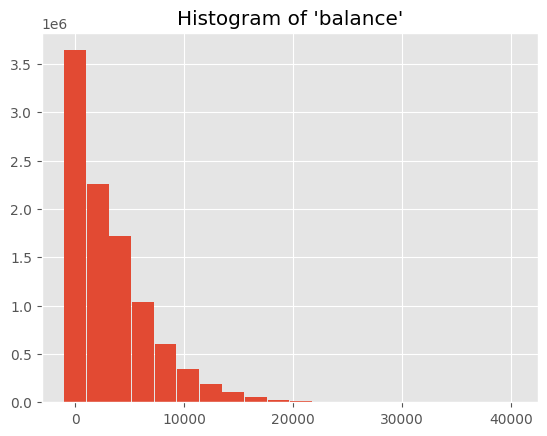

In [47]:
data = {'bins': hists[0][:-1], 'freq': hists[1]}

plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')

In a similar manner, a histogram can be created with Bokeh:

In [62]:
data_bis = data.copy()
df = pd.DataFrame(data_bis)

In [65]:
from bokeh.models import ColumnDataSource, FactorRange

# Convertir la colonne 'bins' en chaînes de caractères formatées
#df['bins'] = df['bins'].map(lambda x: f"{x:.2f}")

# Créer une source de données Bokeh
source = ColumnDataSource(df)

# Créer une figure avec une plage catégorielle pour l'axe x
b_hist = figure(
    x_range=FactorRange(factors=list(df['bins'])),  # Convertir les bins en plage catégorielle
    title="Histogram of 'balance'",
    x_axis_label='Bins',
    y_axis_label='Frequency'
)

# Ajouter un graphique de barres
b_hist.vbar(x='bins', top='freq', width=0.8, source=source, color="dodgerblue")

# Personnaliser les labels pour une meilleure lisibilité
b_hist.xaxis.major_label_orientation = 1.2  # Incliner les labels de l'axe X

# Afficher le graphique
show(b_hist)

Text(0.5, 1.0, "Histogram of 'balance' using .hist()")

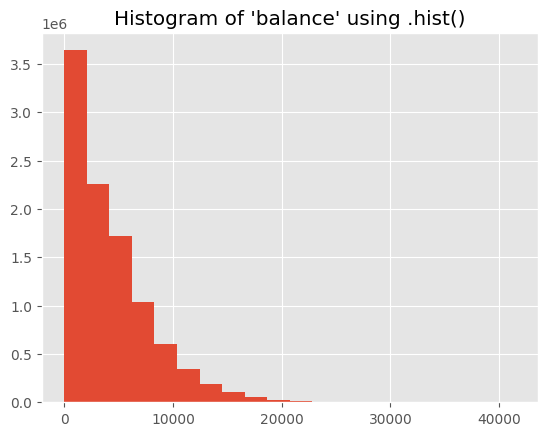

In [66]:
data_driver = {
'obs': fraud_df.select('balance').rdd.flatMap(
lambda row: row
).collect()
}
plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' using .hist()')

### Interactions between features  

Scatter charts allow us to visualize interactions between up to three variables at a
time (although we will be only presenting a 2D interaction in this section).  

Since PySpark does not offer any visualization modules on the server side, and
trying to plot billions of observations at the same time would be highly impractical,
in this section we will sample the dataset at 0.02% (roughly 2,000 observations).

*[Unless you chose a stratified sampling, you should create at least three
to five samples at a predefined sampling fraction so you can check if
your sample is somewhat representative of your dataset—that is, that the
differences between your samples are not big.]*

In this example, we will sample our fraud dataset at 0.02% given 'gender'
as a strata:

In [67]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)

To put multiple 2D charts in one go, you can use the following code:

In [ ]:
data_multi = dict([
    (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) for elem in numerical
])
# instantiating the figure object
sctr = figure(title = "Bokeh Scatter Graph")

# plotting the graph 
sctr.scatter(data_multi['balance'], data_multi['numTrans'])

# displaying the model 
show(sctr) 


As you can see, there are plenty of fraudulent transactions that had 0 balance but
many transactions—that is, a fresh card and big spike of transactions. However, no
specific pattern can be shown apart from some banding occurring at $1,000 intervals.

## Summary
In this chapter, we looked at how to clean and prepare your dataset for modeling
by identifying and tackling datasets with missing values, duplicates, and outliers.
We also looked at how to get a bit more familiar with your data using tools from
PySpark (although this is by no means a full manual on how to analyze your
datasets). Finally, we showed you how to chart your data.
We will use these (and more) techniques in the next two chapters, where we will be
building machine learning models.